## Домашнее задание #1: Морфология и визуализация

*by Марат Богаутдинов, 232*

### Задание 1: Выбор текста и конвертация в UTF-8

В качестве материала работы я выбрал книгу Марселя Пруста "В поисках утраченного времени", часть "Обретенное время" (доступно на [lib.ru](http://lit.lib.ru/g/godin_a/text_0010.shtml), сам текст (без всего лишнего) лежит на гитхабе)

### Задание 2: Обработать книгу с помощью spaCy

#### 1/ Токенизируем, лемматизируем текст и определим части речи для слов

+ импортируем необходимые библиотеки
+ читаем текст из файла
+ обрабатываем текст: убираем всю пунктуацию и числа через метод `.strip()`
+ убираем стоп-слова, список стоп-слов получим из библиотеки `nltk`
+ создаем список `sc_output`, в которой запишем разборы слов в виде словаря с ключами `lemma`, `word` и `pos`

In [466]:
%%time

import spacy, nltk
import ru_core_news_sm
from string import punctuation
from nltk.corpus import stopwords


nlp = ru_core_news_sm.load()

# читаем текст из файла
with open("prust.txt", encoding="utf-8") as text_in:
    raw_txt = text_in.read()

# предварительно обрабатываем текст: убираем пунктуацию и приклеившиеся цифры страниц
txt_with_stopwords = (' '.join([lemma.strip(punctuation + '1234567890').lower() for lemma in raw_txt.split()]))

# уберем стоп-слова
# загружаем стоп-слова для русского языка
nltk.download('stopwords')
sw = stopwords.words('russian')

ready_txt = ' '.join([w for w in txt_with_stopwords.split() if w not in sw])

# лемматизируем и определяем часть речи, создаем переменную output - список словарей разбора каждого токена
doc = nlp(ready_txt)
sc_output = [{"lemma": w.lemma_, "word": w.text, "pos": w.pos_} for w in doc]
sc_output

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mboga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: total: 21.3 s
Wall time: 29 s


[{'lemma': 'марсель', 'word': 'марсель', 'pos': 'NOUN'},
 {'lemma': 'пруст', 'word': 'пруст', 'pos': 'VERB'},
 {'lemma': 'обретенное', 'word': 'обретенное', 'pos': 'ADJ'},
 {'lemma': 'время', 'word': 'время', 'pos': 'NOUN'},
 {'lemma': 'стоить', 'word': 'стоило', 'pos': 'VERB'},
 {'lemma': 'рассказывать', 'word': 'рассказывать', 'pos': 'VERB'},
 {'lemma': 'поездка', 'word': 'поездке', 'pos': 'NOUN'},
 {'lemma': 'окрестность', 'word': 'окрестности', 'pos': 'NOUN'},
 {'lemma': 'комбре', 'word': 'комбре', 'pos': 'NOUN'},
 {'lemma': 'тот', 'word': 'ту', 'pos': 'DET'},
 {'lemma': 'пора', 'word': 'пору', 'pos': 'NOUN'},
 {'lemma': 'мой', 'word': 'моей', 'pos': 'DET'},
 {'lemma': 'жизнь', 'word': 'жизни', 'pos': 'NOUN'},
 {'lemma': 'комбре', 'word': 'комбре', 'pos': 'PROPN'},
 {'lemma': 'думать', 'word': 'думал', 'pos': 'VERB'},
 {'lemma': 'маленький', 'word': 'меньше', 'pos': 'ADV'},
 {'lemma': 'именно', 'word': 'именно', 'pos': 'PART'},
 {'lemma': 'пусть', 'word': 'пусть', 'pos': 'PART'},
 

#### 2/ Сохраним получившуюся выдачу в `.jsonl`-файл

Импортируем модуль `json` и записываем каждый словарь разбора токенов в файл

In [467]:
import json


with open("spacy_lem_word_pos.jsonl", "w", encoding="utf-8") as outfile:
    for w in sc_output:
        outfile.write(json.dumps(w, ensure_ascii=False) + '\n')

#### 3/ Создадим датафрейм со столбцами $-$ lemma, pos, frequency и сохраним его в файл `.csv`

+ сначала создадим датафрейм из двух колонок $-$ `lemma`, `pos`, на основе которых уже потом подсчитаем частоту вхождений лемм
+ для подсчета частот создаем новую колонку, которая будет учитывать как лемму, так и ее часть речи $-$ далее по ней подсчитаем, сколько вхождений каждого вида есть в этой временной колонке
+ убираем временную колонку `lemma-pos`, избавляемся от дублирующихся строк с помощью метода `.drop_duplicates()` и сортируем датафрейм сначала по столбцу `frequency` по убыванию, а при равенстве значений $-$ по столбцу `lemma` по лексикографическому возрастанию
+ создаем файл `.csv` и записываем туда датафрейм без индексов с помощью метода `.to_csv` (указываем `index=False`, чтобы индексы не передались в файл)

In [491]:
import pandas as pd

# создадим сначала две колонки - lemma и pos, а frequency вычислим уже на основе созданного датафрейма
col = {'lemma': [lem['lemma'] for lem in sc_output],
      'pos': [lem['pos'] for lem in sc_output]}
sc_freq = pd.DataFrame(col)

# создание временной колонки
sc_freq['lemma-pos'] = sc_freq['lemma'] + '-' + sc_freq['pos']

# подсчет частотности лемм по новой колонке
lemma_counter = sc_freq['lemma-pos'].value_counts()

# с помощью метода .map() поэлементно записываем частоты в новую колонку frequency
sc_freq['frequency'] = sc_freq['lemma-pos'].map(lemma_counter)

# удаляем временную колонкуто
sc_freq = sc_freq.drop(columns=['lemma-pos'])

# избавляемся от дублирующихся лемм, сортируем значения по двум колонкам
sc_freq = sc_freq.drop_duplicates(subset=['lemma', 'pos']).sort_values(by=['frequency', 'lemma'], ascending=[False, True])

# экспортируем датафрейм в файл
with open('spacy_lem_word_pos.csv', 'w', encoding='utf-8') as outfile:
    sc_freq.to_csv('spacy_lem_word_pos.csv', index=False) 

sc_freq

,lemma,pos,frequency
1298,де,PART,542
474,свой,DET,501
282,это,PRON,490
9,тот,DET,430
243,человек,NOUN,428
...,...,...,...
12890,яром,ADJ,1
49530,ярь,NOUN,1
36345,ёмкий,ADJ,1
24732,‑й,PROPN,1


### Задание 3: Обработать книгу через Pymorphy

#### 1/ Токенизируем текст с помощью `nltk` и уберем стоп-слова

+ импортируем библиотеку и выгружаем список стоп-слов для русского языка в переменную `sw`
+ токенизируем текст: оставляем только буквоподобные символы и приводим к нижнему регистру, а потом фильтруем по наличию в списке стоп-слов; получаем список слов `filtered_words` 

In [470]:
%%time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# загружаем стоп-слова для русского языка
# в целом мы их уже загрузили в эту же переменную раньше, но можем и повторить эту процедуру
nltk.download('stopwords')
sw = stopwords.words('russian')

# токенизируем слова и избавляемся от стоп-слов
words = [w.lower() for w in word_tokenize(raw_txt, language='russian') if w.isalpha()]
filtered_words = [w for w in words if w not in sw]

filtered_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mboga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: total: 594 ms
Wall time: 763 ms


['марсель',
 'пруст',
 'обретенное',
 'время',
 'стоило',
 'рассказывать',
 'поездке',
 'окрестности',
 'комбре',
 'ту',
 'пору',
 'моей',
 'жизни',
 'комбре',
 'думал',
 'меньше',
 'именно',
 'пусть',
 'предварительно',
 'подтвердились',
 'мысли',
 'впервые',
 'посетившие',
 'стороне',
 'германта',
 'также',
 'другие',
 'пришедшие',
 'стороне',
 'каждый',
 'вечер',
 'снова',
 'отправлялся',
 'прогулку',
 'хотя',
 'другом',
 'направлении',
 'комбре',
 'гуляли',
 'днем',
 'мезеглиза',
 'тансонвиле',
 'ужинали',
 'час',
 'комбре',
 'те',
 'времена',
 'давно',
 'спали',
 'поскольку',
 'стояла',
 'жара',
 'днем',
 'жильберта',
 'рисовала',
 'дворцовой',
 'часовне',
 'выходили',
 'раньше',
 'часа',
 'ужина',
 'раньше',
 'возвращаясь',
 'домой',
 'любовался',
 'багряные',
 'небеса',
 'окаймившие',
 'кальварий',
 'плещущиеся',
 'вивоне',
 'полюбил',
 'другое',
 'бродить',
 'сумерках',
 'деревне',
 'никого',
 'встретишь',
 'лишь',
 'голубоватый',
 'неправильный',
 'подвижный',
 'треугольник',


#### 2/ Разберем слова с помощью Pymorphy

+ импортируем `MorphAnalyzer` из `pymorphy3` и создадим морфологический анализатор `morph`
+ создадим список `pm_output`, в который будем добавлять разборы слов в виде словарей с ключами `lemma`, `word` и `pos`
+ в цикле для каждого слова определяем лемму и часть речи, а потом добавляем в `pm_output` словарь с разбором слова

In [ ]:
from pymorphy3 import MorphAnalyzer


morph = MorphAnalyzer()

# список, куда будем записывать получившиеся разборы слов
pm_output = []

# цикл, в котором для каждого токена из списка токенизированных слов определяем лемму и часть речи и записываем в итоговый список разборов output 
for w in filtered_words:
    lemma = morph.parse(w)[0].normal_form
    pos = morph.parse(w)[0].tag.POS
    pm_output.append({"lemma": lemma, "word": w, "pos": pos})

pm_output

#### 3/ Сохраним получившуюся выдачу в `.jsonl`-файл

Импортируем модуль `json` и записываем каждый словарь разбора токенов в файл

In [472]:
import json


with open("pymorphy_lem_word_pos.jsonl", "w", encoding="utf-8") as outfile:
    for w in pm_output:
        outfile.write(json.dumps(w, ensure_ascii=False) + '\n')

#### 4/ Создадим датафрейм со столбцами $-$ lemma, pos, frequency и сохраним его в файл `.csv`

На самом деле, код не будет отличаться от того, который использовался для обработанного `spaCy` текста, но я повторю шаги:
   + сначала создадим датафрейм из двух колонок $-$ `lemma`, `pos`, на основе которых уже потом подсчитаем частоту вхождений лемм
   + для подсчета частот создаем новую колонку, которая будет учитывать как лемму, так и ее часть речи $-$ далее по ней подсчитаем, сколько вхождений каждого вида есть в этой временной колонке
   + убираем временную колонку `lemma-pos`, избавляемся от дублирующихся строк с помощью метода `.drop_duplicates()` и сортируем датафрейм сначала по столбцу `frequency` по убыванию, а при равенстве значений $-$ по столбцу `lemma` по лексикографическому возрастанию, и убираем строки с NaN
   + создаем файл `.csv` и записываем туда датафрейм без индексов с помощью метода `.to_csv` (указываем `index=False`, чтобы индексы не передались в файл)

In [477]:
import pandas as pd

# создадим сначала две колонки - lemma и pos, а frequency вычислим уже на основе созданного датафрейма
col = {'lemma': [lem['lemma'] for lem in pm_output],
      'pos': [lem['pos'] for lem in pm_output]}
pm_freq = pd.DataFrame(col)

# создание временной колонки
pm_freq['lemma-pos'] = pm_freq['lemma'] + '-' + pm_freq['pos']

# подсчет частотности лемм по новой колонке
lemma_counter = pm_freq['lemma-pos'].value_counts()

# с помощью метода .map() поэлементно записываем частоты в новую колонку frequency
pm_freq['frequency'] = pm_freq['lemma-pos'].map(lemma_counter)

# удаляем временную колонкуто
pm_freq = pm_freq.drop(columns=['lemma-pos'])

# избавляемся от дублирующихся лемм, сортируем значения сначала по двум колонкам
pm_freq = pm_freq.drop_duplicates(subset=['lemma', 'pos']).sort_values(by=['frequency', 'lemma'], ascending=[False, True]).dropna()

# экспортируем датафрейм в файл
with open('pymorphy_lem_word_pos.csv', 'w', encoding='utf-8') as outfile:
    pm_freq.to_csv('pymorphy_lem_word_pos.csv', index=False)

pm_freq

,lemma,pos,frequency
162,который,ADJF,1056.0
199,это,PRCL,628.0
1224,де,PRCL,606.0
448,свой,ADJF,500.0
9,тот,ADJF,471.0
...,...,...,...
66430,яркость,NOUN,1.0
14171,ярлык,NOUN,1.0
6545,ярлычок,NOUN,1.0
11870,ярый,ADJF,1.0


### Задание 4: Анализ и визуализация

#### 1/ Доля каждой части речи

Прежде чем подсчитывать долю каждой части речи, вероятно, стоит свести все части речи к единым наименованиям, поскольку в стандартах [`Pymorphy`](https://pymorphy2.readthedocs.io/en/latest/user/grammemes.html) и [`spaCy`](https://universaldependencies.org/u/pos/) они различаются. Была принята следующая стратегия:
+ если в обоих стандартах есть одинаковые части речи, то такая часть речи остается;
+ если в обоих стандартах есть по смыслу одинаковые части речи, но называющиеся по-разному, то принимается вариант `spaCy`, основанный на стандартах `UD`
+ если в одном стандарте часть речи дробится на более мелкие, а в другом есть объединяющая для них категория, то выбирается более широкая часть речи, покрывающая более мелкие;
+ если в обоих стандартах имеются дробные части речи, которые невозможно свести, то для них создается отдельная категория.

Таким образом, мы получаем следующую таблицу переходов:

| категория Pymorphy            | категория spaСy | итог |
|-------------------------------|-----------------|------|
| NOUN                          | NOUN PROPN      | NOUN |
| VERB INFN PRTF PRTS GRND PRED | VERB AUX        | VERB |
| ADVB                          | ADV             | ADV  |
| PREP                          | ADP             | ADP  |
| ADJF ADJS COMP                | ADJ             | ADJ  |
| NUMR                          | NUM             | NUM  |
| NPRO                          | PRON DET        | PRON |
| CONJ                          | CCONJ SCONJ     | CONJ |
| PRCL                          | PART            | PART |
| INTJ                          | INTJ            | INTJ |
| PNCT                          | PUNCT           | PUNCT|

И в таком случае для анализа и визуализации необходимо совершить следующие шаги:
+ привести все части речи согласно таблице переходов: сделать это можно, применив метод `.apply()` к `Series`, в котором мы пропишем lambda-функцию, обращающуюся к словарю переходов pos_dict
+ получаем частоты: сначала вычисляем общее количество слов в каждом датафрейме, потом количество слов каждой части речи делим на это общее число слов и округляем до 3 знаков после запятой
+ и создаем датафрейм com_freq_df (*< common frequencies dataframe*), в котором индексами выступят части речи, а значениями по столбцами `spaCy` и `Pymorphy` $-$ частоты
+ немного меняем датафрейм для визуализации: с помощью метода `.reset_index()` устанавливаем числовые индексы, а части речи становятся отдельной колонкой; с помощью `.melt()` устанавливаем метод (`spaCy`, `Pymorphy`) отдельной колонкой
+ визуализируем данные с помощью библиотек `matplotlib` и `seaborn`: выбираем график столбчатых диаграмм и настраиваем график

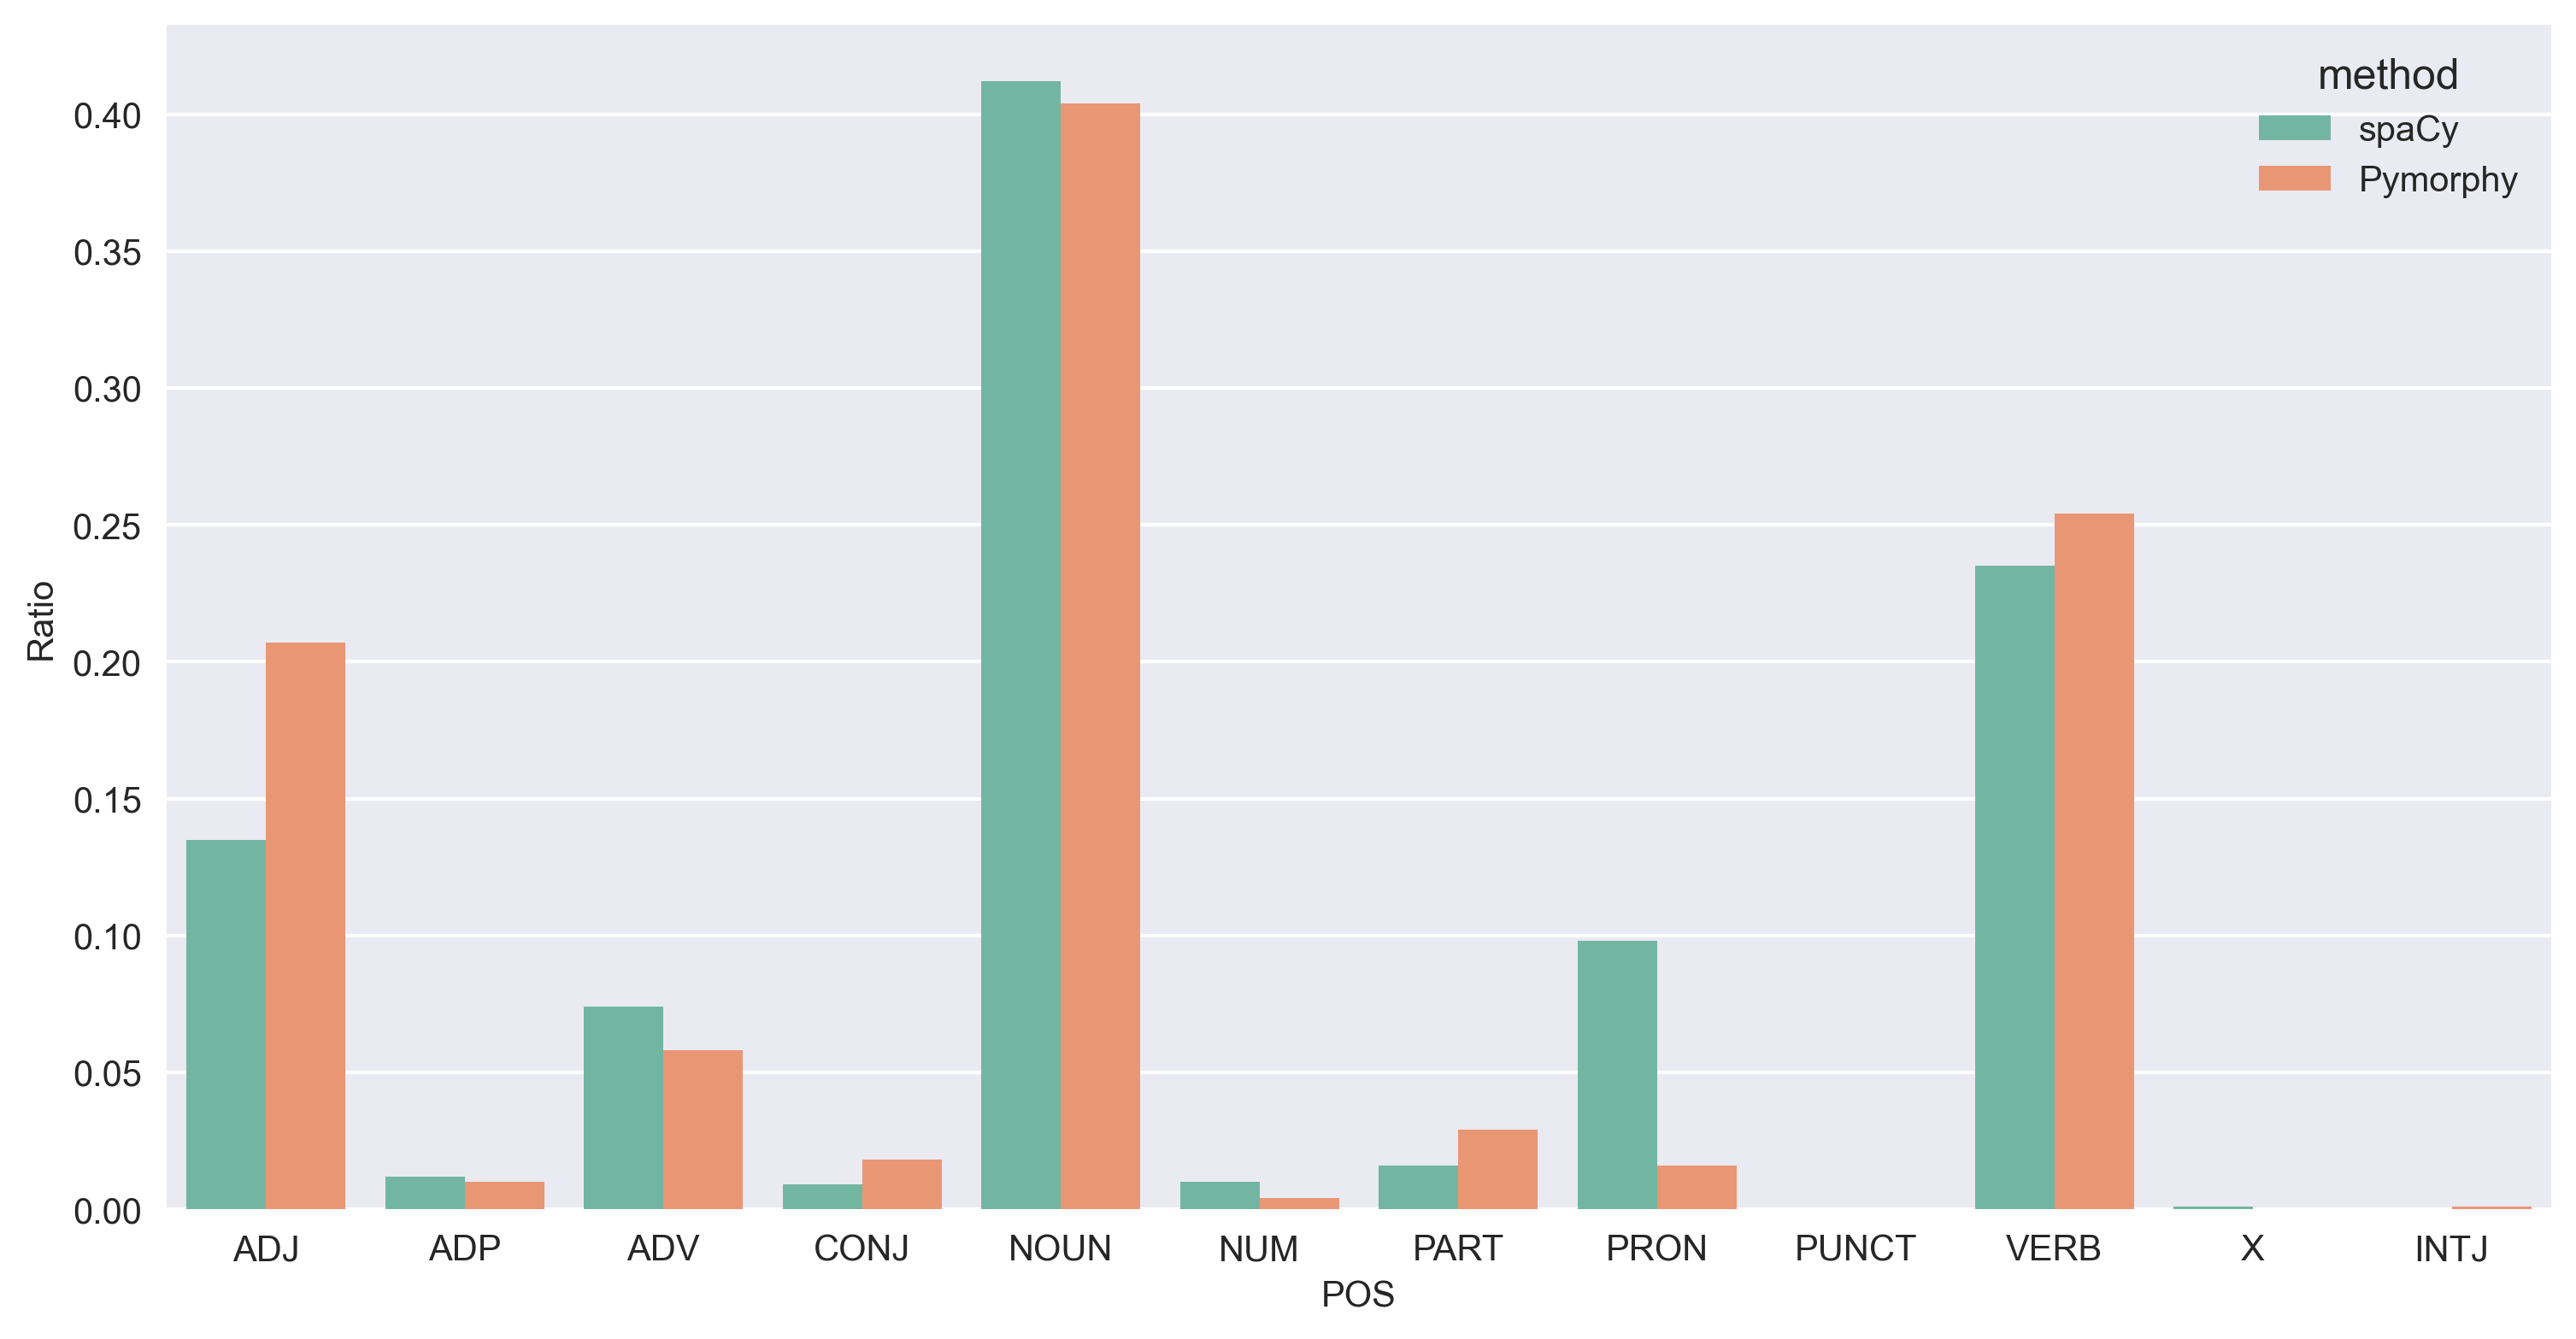

,pos,variable,value
0,ADJ,spaCy,0.135
1,ADP,spaCy,0.012
2,ADV,spaCy,0.074
3,CONJ,spaCy,0.009
5,NOUN,spaCy,0.412
6,NUM,spaCy,0.010
7,PART,spaCy,0.016
8,PRON,spaCy,0.098
9,PUNCT,spaCy,0.000
10,VERB,spaCy,0.235


In [479]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# словарь переходов одних частей речи в другую
pos_dict = {'NOUN': 'NOUN', 
            'PROPN': 'NOUN', 
            'VERB': 'VERB', 
            'INFN': 'VERB', 
            'PRTF': 'VERB', 
            'PRTS': 'VERB', 
            'GRND': 'VERB', 
            'PRED': 'VERB',
            'AUX': 'VERB',
            'ADVB': 'ADV',
            'ADV': 'ADV',
            'PREP': 'ADP',
            'ADP': 'ADP',
            'ADJF': 'ADJ',
            'ADJS': 'ADJ',
            'COMP': 'ADJ',
            'NUMR': 'NUM',
            'NUM': 'NUM',
            'NPRO': 'PRON',
            'PRON': 'PRON',
            'DET': 'PRON',
            'CONJ': 'CONJ',
            'CCONJ': 'CONJ',
            'SCONJ': 'CONJ',
            'PRCL': 'PART',
            'PART': 'PART',
            'INTJ': 'INTJ',
            'PNCT': 'PUNCT',
            'PUNCT':'PUNCT'}

# применяем apply() к столбцам pos в датафреймах, чтобы привести все части речи к одному стандарту
pm_freq['pos'] = pm_freq['pos'].apply(lambda pos: pos_dict[pos] if pos in pos_dict else pos)
sc_freq['pos'] = sc_freq['pos'].apply(lambda pos: pos_dict[pos] if pos in pos_dict else pos)

# вычисляем общее количество слов в тексте
sc_sum = sum(sc_freq['frequency'])
pm_sum = sum(pm_freq['frequency'])

# создаем новый датафрейм с долями частей речи от всех слов по разбору от spaCy и Pymorphy
com_freq_df = pd.DataFrame({'spaCy': sc_freq.groupby('pos').agg({'frequency': 'sum'})['frequency'].apply(lambda num: round(num / sc_sum, 3)),
                            'Pymorphy': pm_freq.groupby('pos').agg({'frequency': 'sum'})['frequency'].apply(lambda num: round(num / pm_sum, 3))})

# и немного его преобразуем для удобства визуализации
com_freq_df = com_freq_df.reset_index().melt(id_vars=['pos'], value_vars=['spaCy', 'Pymorphy']).dropna()

# создаем визуализацию: определяем размеры всей диаграммы, устанавливаем данные, называем оси и приписываем легенду
plt.figure(figsize=(12, 6), dpi=300)
sns.barplot(data=com_freq_df, x='pos', y='value', hue='variable', palette='Set2')
plt.xlabel('POS', fontsize=10)
plt.ylabel('Ratio', fontsize=10)
plt.legend(title='method', title_fontsize=12, fontsize=10)

# выводим графичек и датасет
plt.show()
com_freq_df

**Сравнение результатов**

Какие наблюдения можно сделать:
1. Доля существительных при обоих разборах примерно равна.
2. Разница между разборами в `ADJ` как будто компенсируется за счет разборов в `PRON`: вероятно, это говорит о том, что наша таблица переходов изначально была не совсем верной, и то, что в `spaCy` имеет часть речи `DET`, в `Pymorphy` соответствует `ADJ`, а не `PRON`. Это значит, что слова типа *этот, свой, другой, каждый* и нек. др. (т.н. группа местоимений-прилагательных, `APRON`) в `Pymorphy` относятся к классу прилагательных, а не местоимений.
3. Возможно, похожим образом можно объяснить разницы в столбцах `VERB` и `ADV`: группа предикативов, которая в `Pymorphy` выделяется отдельно, может быть разобрана в `spaCy` как наречия (`ADV`), а не глаголы.

#### \2 Топ-20 глаголов и наречий

+ импортируем `warnings`, чтобы лишний раз не волноваться (бережем нервы)
+ находим для каждого датасета топ-20 глаголов и наречий и записываем в единый датасет `all_freq`, чтобы оттуда уже брать данные
+ создаем четыре графика в одной фигуре, воспользовавшись методом `.subplots()`
+ для каждого графика устанавливаем название, подписываем оси и рисуем сами графики с помощью `seaborn.barplot()`

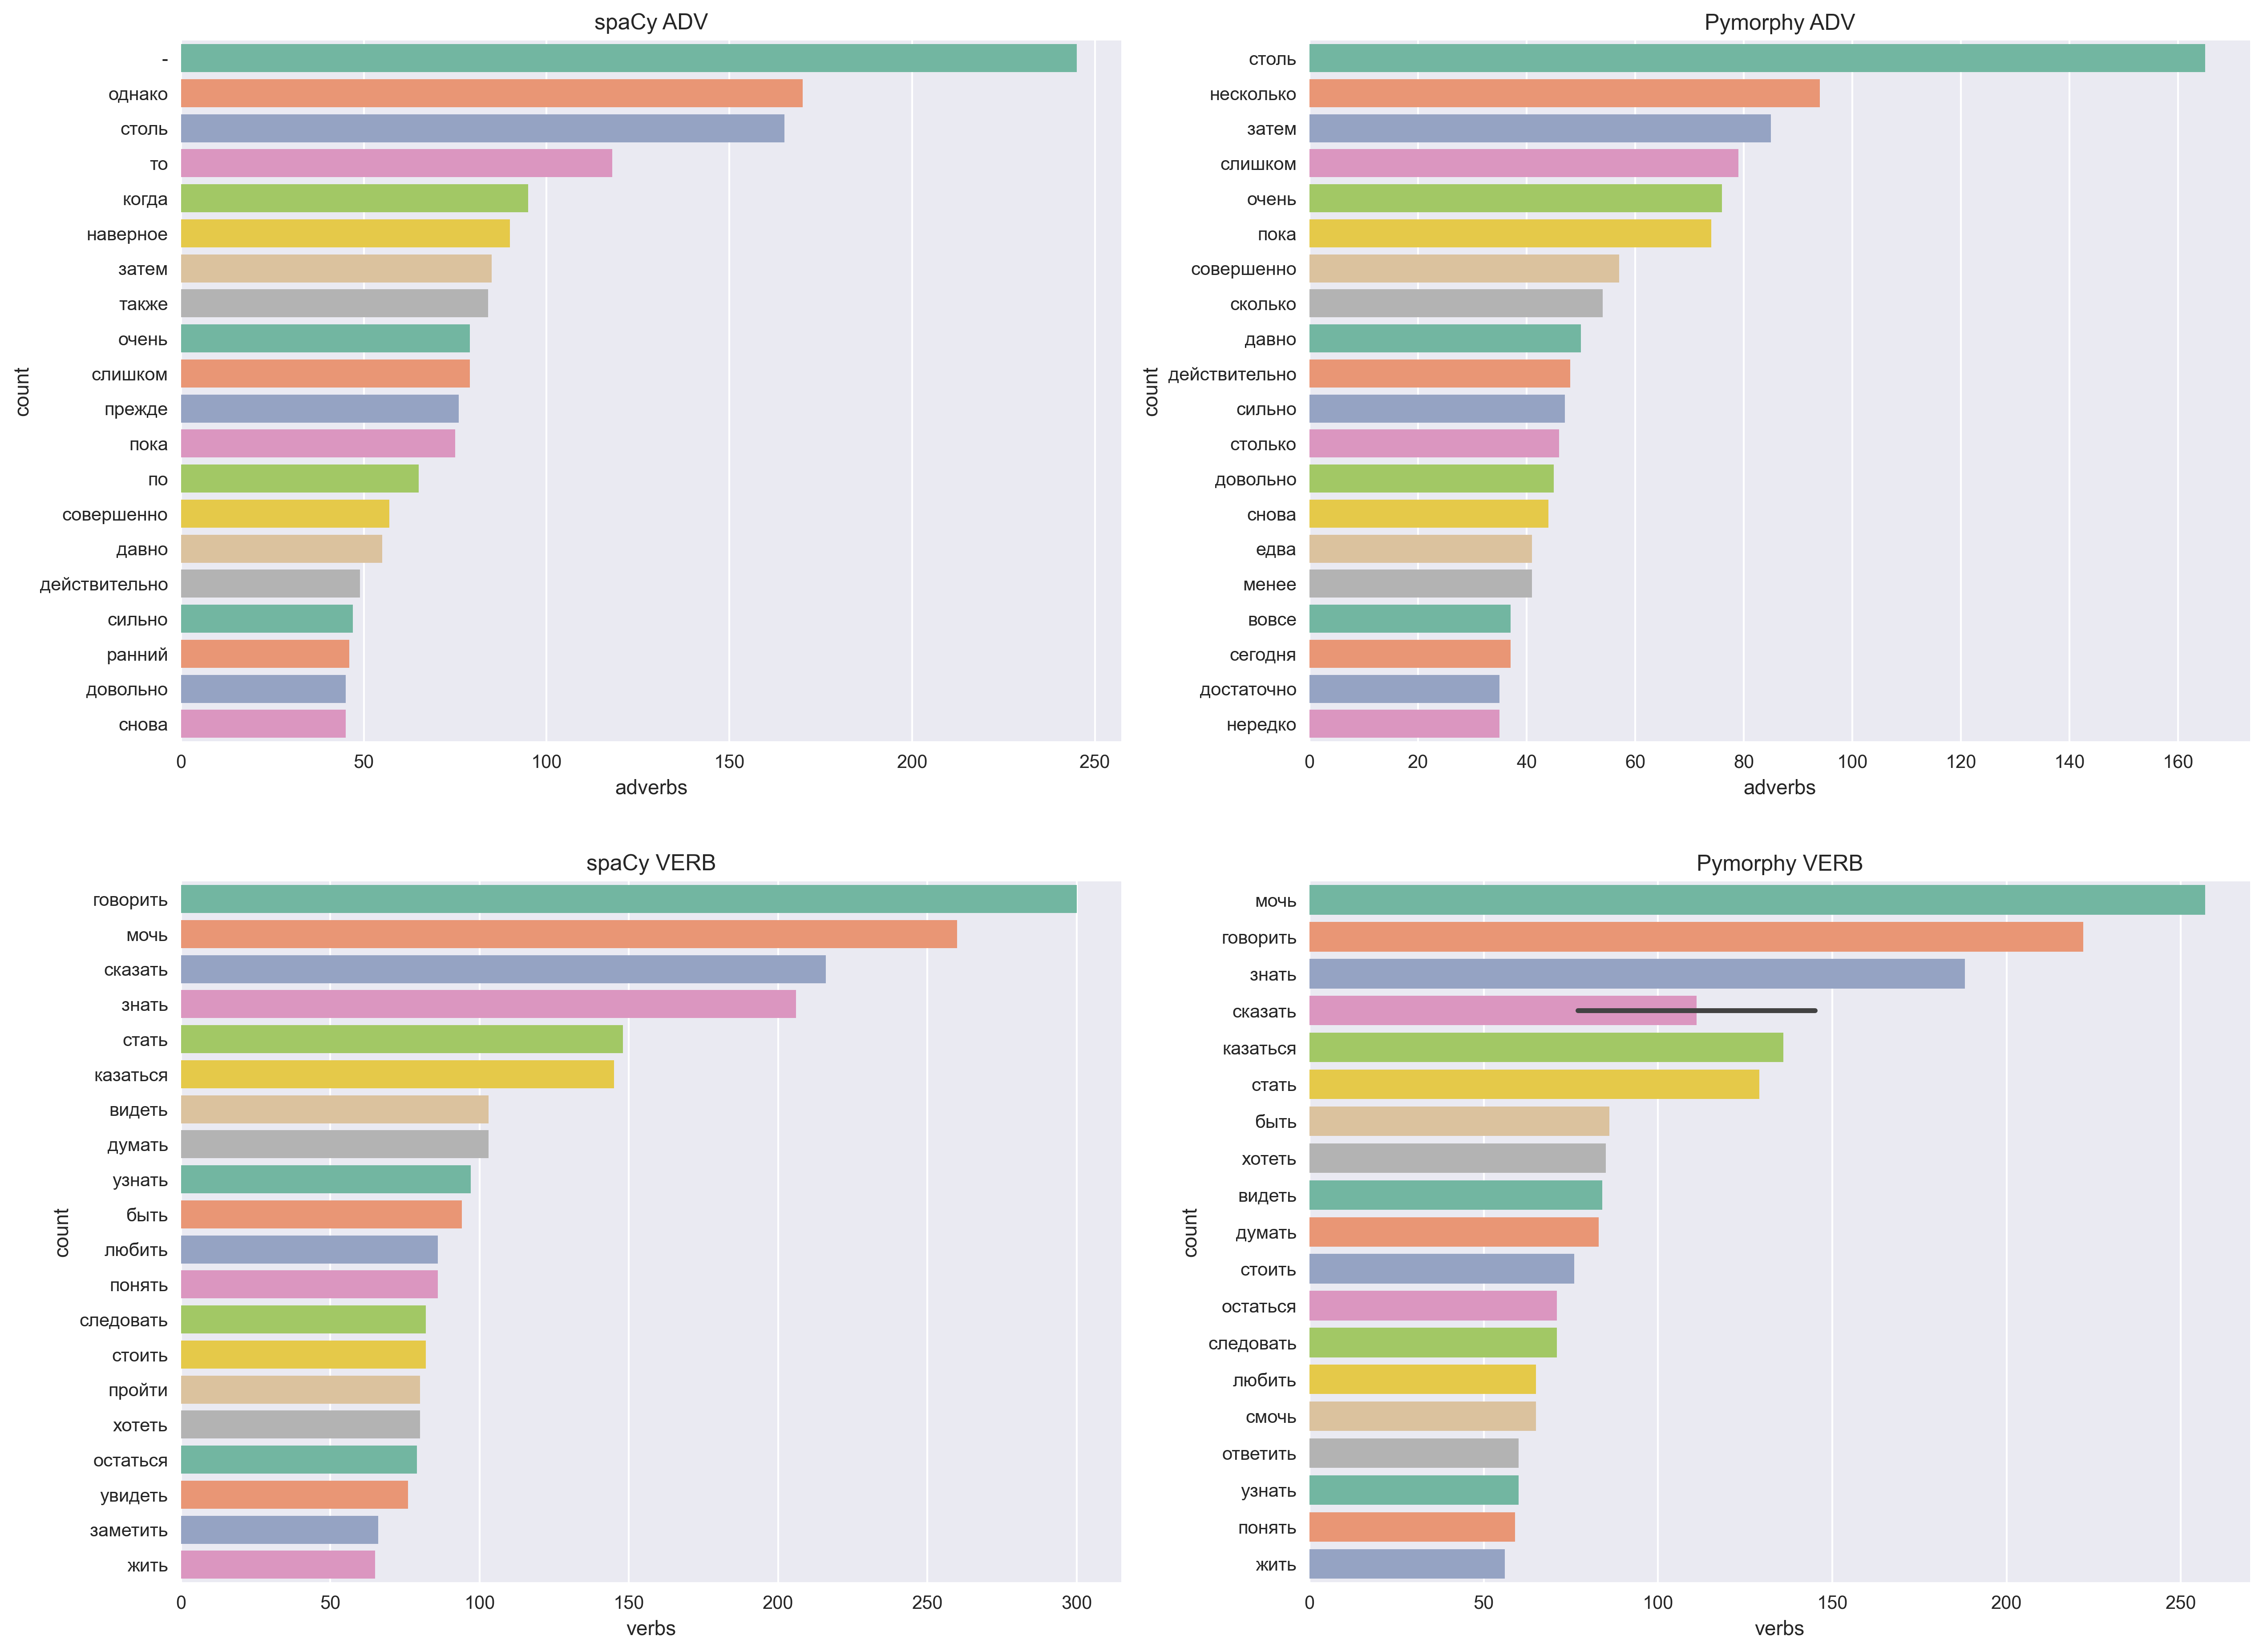

,spaCy adv lemma,spaCy adv freq,Pymorphy adv lemma,Pymorphy adv freq,spaCy verb lemma,spaCy verb freq,Pymorphy verb lemma,Pymorphy verb freq
0,-,245,столь,165.0,говорить,300,мочь,257.0
1,однако,170,несколько,94.0,мочь,260,говорить,222.0
2,столь,165,затем,85.0,сказать,216,знать,188.0
3,то,118,слишком,79.0,знать,206,сказать,145.0
4,когда,95,очень,76.0,стать,148,казаться,136.0
5,наверное,90,пока,74.0,казаться,145,стать,129.0
6,затем,85,совершенно,57.0,видеть,103,быть,86.0
7,также,84,сколько,54.0,думать,103,хотеть,85.0
8,очень,79,давно,50.0,узнать,97,видеть,84.0
9,слишком,79,действительно,48.0,быть,94,думать,83.0


In [480]:
import warnings


warnings.filterwarnings("ignore")

# вычисляем всю дату
pm_verb = pm_freq[pm_freq['pos'] == 'VERB'].head(20).reset_index(drop=True)
pm_adv = pm_freq[pm_freq['pos'] == 'ADV'].head(20).reset_index(drop=True)
sc_verb = sc_freq[sc_freq['pos'] == 'VERB'].head(20).reset_index(drop=True)
sc_adv = sc_freq[sc_freq['pos'] == 'ADV'].head(20).reset_index(drop=True)

# записываем вычисленную дату в новый датафрейм
all_freq = pd.DataFrame({'spaCy adv lemma': sc_adv['lemma'],
                         'spaCy adv freq': sc_adv['frequency'],
                         'Pymorphy adv lemma': pm_adv['lemma'],
                         'Pymorphy adv freq': pm_adv['frequency'],
                         'spaCy verb lemma': sc_verb['lemma'],
                         'spaCy verb freq': sc_verb['frequency'],
                         'Pymorphy verb lemma': pm_verb['lemma'],
                         'Pymorphy verb freq': pm_verb['frequency'],})

# создает матрицу для графиков
fig, axs = plt.subplots(2, 2, figsize=(20, 15), dpi=300) 

# рисуем графики
axs[0, 0].set_title("spaCy ADV")
sns.barplot(data=all_freq, x='spaCy adv freq', y='spaCy adv lemma', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_ylabel("count")
axs[0, 0].set_xlabel("adverbs")

axs[0, 1].set_title("Pymorphy ADV")
sns.barplot(data=all_freq, x='Pymorphy adv freq', y='Pymorphy adv lemma', palette='Set2', ax=axs[0, 1])
axs[0, 1].set_ylabel("count")
axs[0, 1].set_xlabel("adverbs")

axs[1, 0].set_title("spaCy VERB")
sns.barplot(data=all_freq, x='spaCy verb freq', y='spaCy verb lemma', palette='Set2', ax=axs[1, 0])
axs[1, 0].set_ylabel("count")
axs[1, 0].set_xlabel("verbs")

axs[1, 1].set_title("Pymorphy VERB")
sns.barplot(data=all_freq, x='Pymorphy verb freq', y='Pymorphy verb lemma', palette='Set2', ax=axs[1, 1])
axs[1, 1].set_ylabel("count")
axs[1, 1].set_xlabel("verbs")

# выводим графички и датасет
plt.show()
all_freq

**Сравнение результатов**

Какие наблюдения можно сделать тут:
1. `Pymorphy` однозначно лучше определяет части речи: все из представленных топ-20 наречий и глаголов действительно представляют свои частеречные классы, в то время как морфологический анализ `spaCy` пропустил и предлог *по*, и прилагательное *ранний*, и союз *когда*, и частицу/местоимение *то*, и пунктуационный знак *-* (хотя в анализаторе есть отдельный класс для пунктуационных знаков).
2. В анализе `Pymorphy` почему-то выделилось два глагола *сказать*, которые не слились при сливании одинаковых лемм (не смог выяснить, что случилось). Именно поэтому на графике бар для глагола *сказать* дан усредненно по двум значениям (77 и 145)
3. В остальном разборы примерно похожи между собой, хотя есть некоторые достаточно внушительные количественные отличия: для леммы *говорить* $-$ 300 vs 222 вхождения и проч.

#### \3 Облако слов

+ словари с леммами хранятся, в частности, в списке `pm_output` $-$ используем его
+ импортируем из библиотеки `wordcloud` класс `WordCloud`
+ настраиваем наше облако
+ выводим облако в фигуре, которую создаем с помощью `matplotlib`

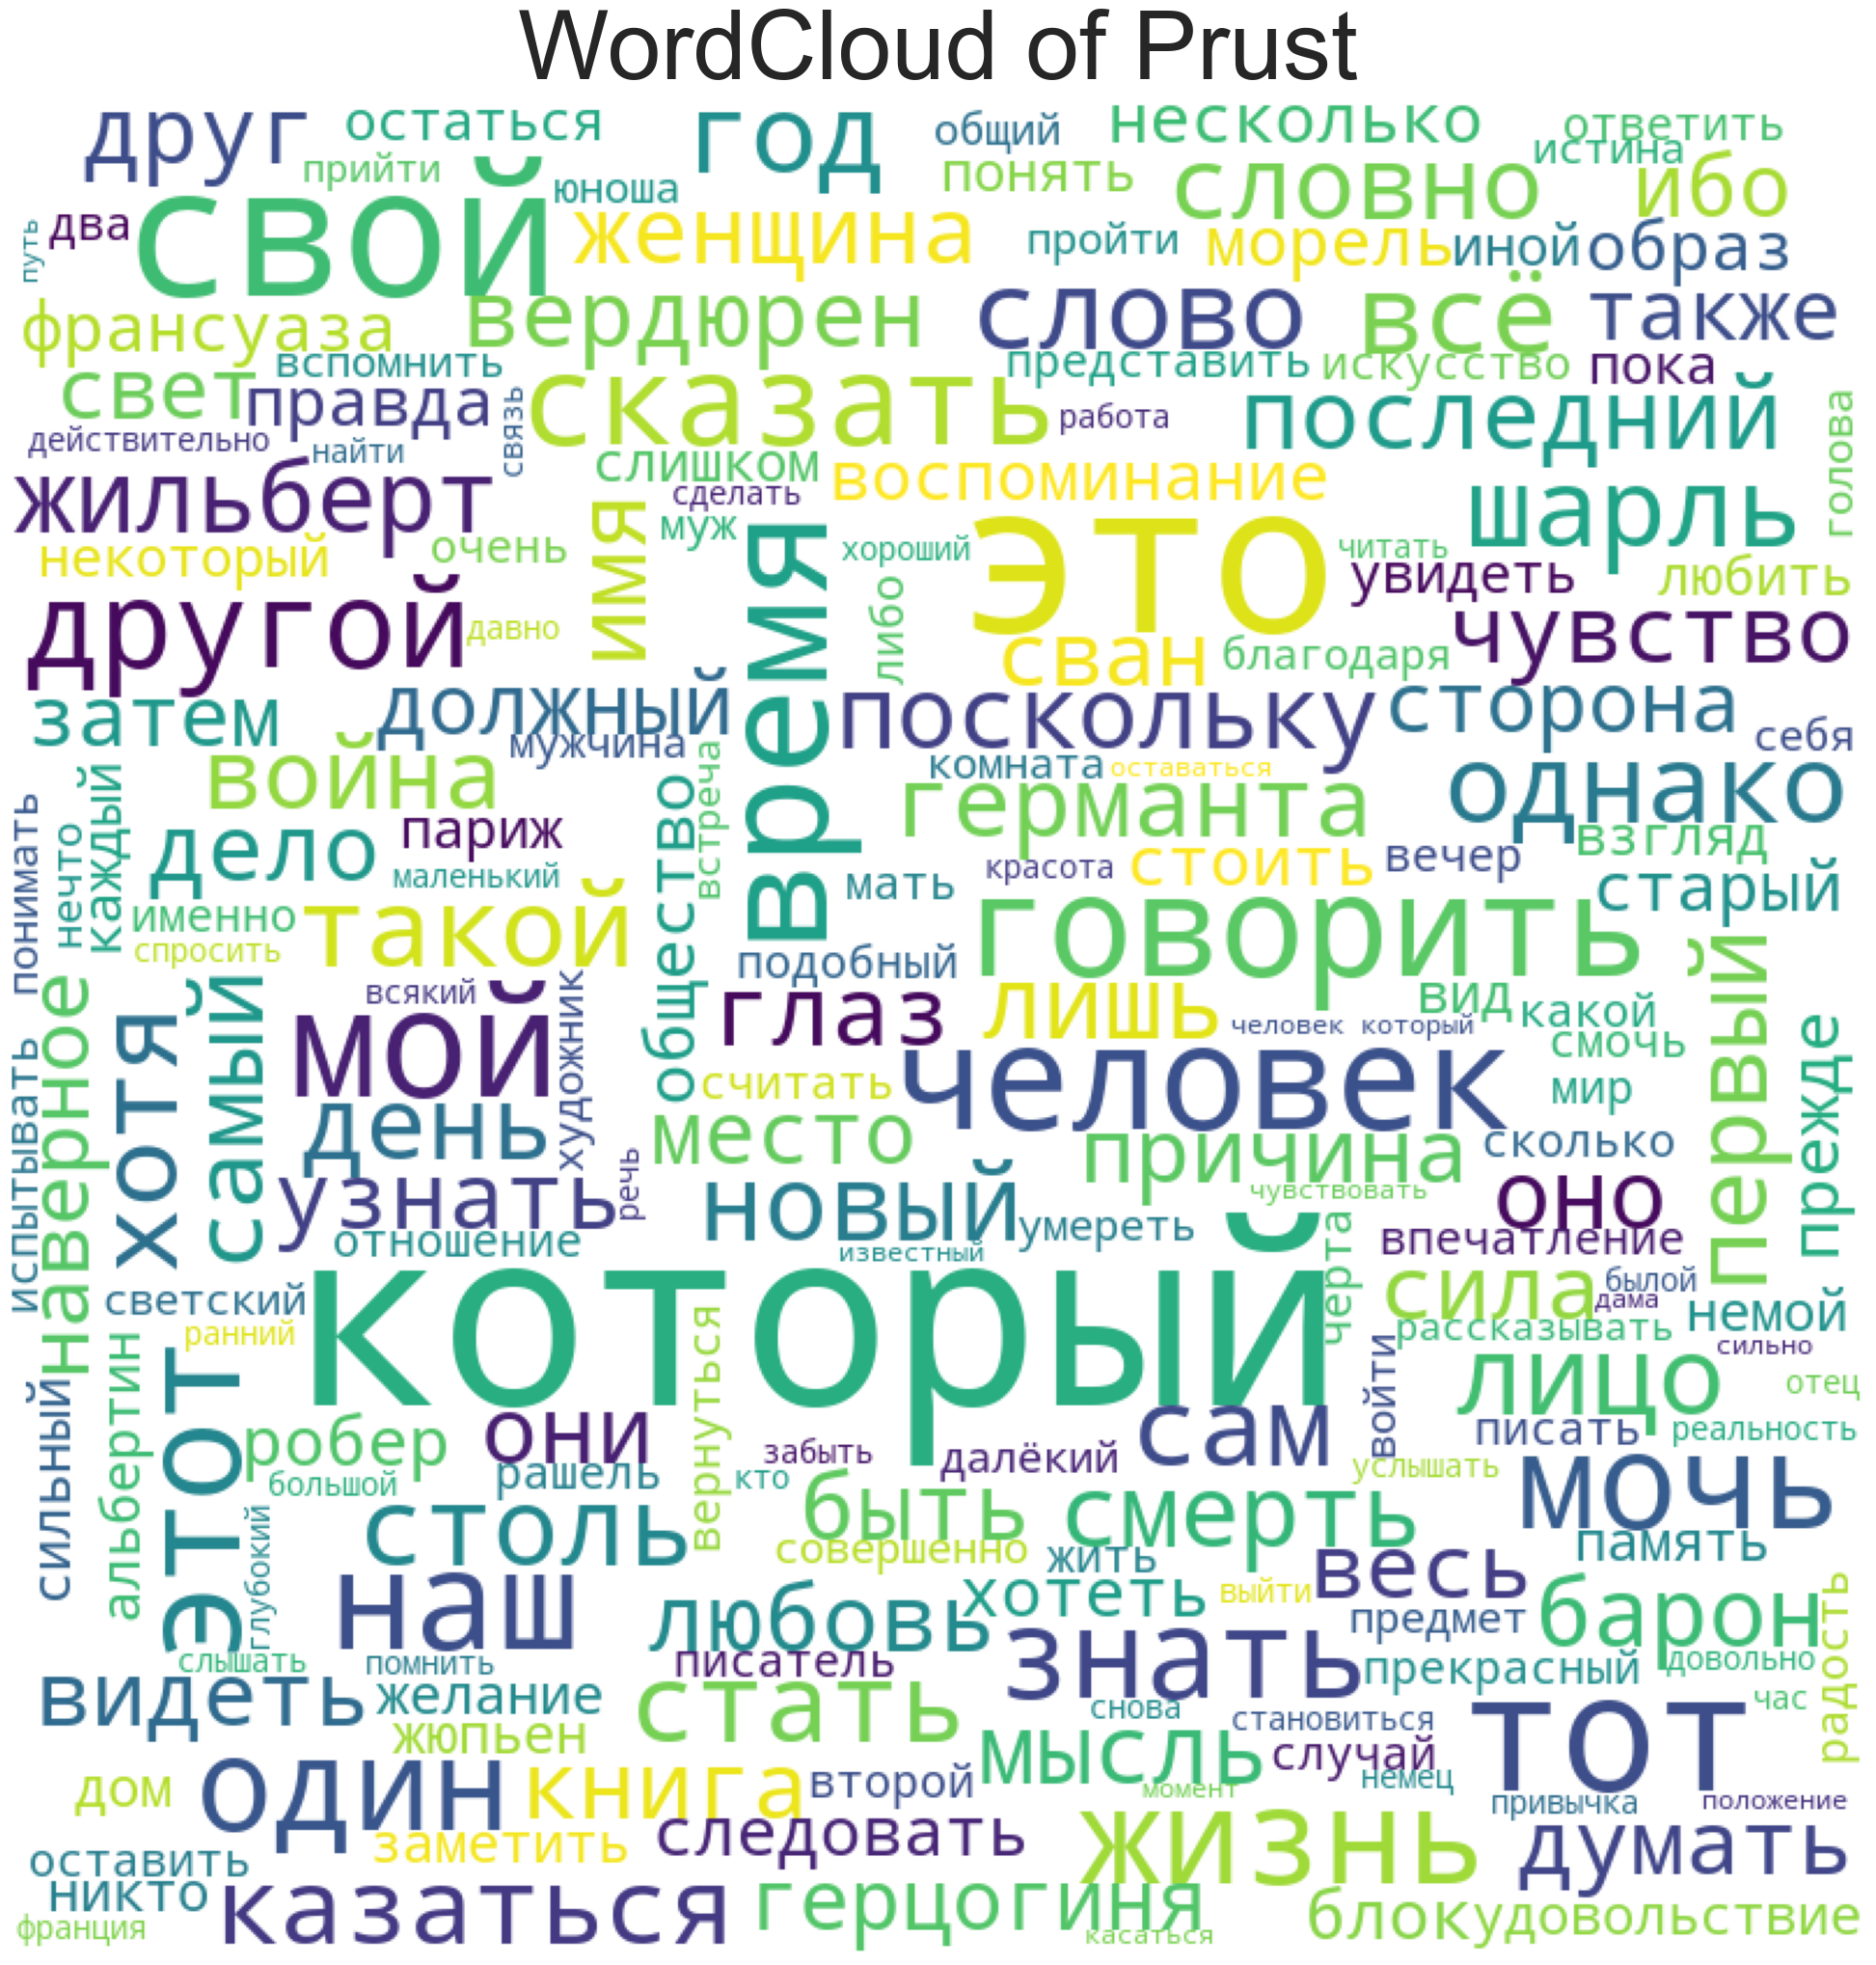

In [485]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=800,
    min_word_length=3,
    max_font_size=108
).generate(' '.join([w['lemma'] for w in pm_output]))

plt.figure(figsize=(25, 25), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud of Prust', fontsize=72)
plt.show()

### Задание 5: Составление N-грамм

#### 1/ Подсчитаем биграммы и триграммы в тексте

+ импортируем метод `ngrams` из `nltk.util` библиотеки `nltk`,
+ поскольку мы хотим посмотреть N-граммы, то стоп-слова, наверное, не стоит исключать $-$ поэтому токенизируем текст и лемматизируем слова заново с помощью `nltk`-токенизатора и `pymorphy3`-парсера
+ найдем N-граммы (N=2,3) в получившемся списке лемм `lemmas`
+ создадим два датафрейма $-$ `bi`, `tri`, в которые поместим биграммы и триграммы, соответственно
+ внутри каждого датафрейма подсчитаем количество вхождений каждой n-граммы, оставим только уникальные n-граммы (=удалим повторяющиеся), отсортируем по убывания частотности (при равенстве значений $-$ по лексикографическому возрастанию) и выведем топ-25 среди би- и триграмм  

In [486]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from pymorphy3 import MorphAnalyzer

# создаем список лемм нашего текста
morph = MorphAnalyzer()
lemmas = [morph.parse(w.lower())[0].normal_form for w in word_tokenize(raw_txt, language='russian') if w.isalpha()]

# составляем список би- и триграмм
bigrams = list(ngrams(lemmas, 2))
trigrams = list(ngrams(lemmas, 3))

# и загоним все в два датасета, чтобы было легче анализировать
bi = pd.DataFrame({'bigrams': bigrams})
tri = pd.DataFrame({'trigrams': trigrams})

# подсчитаем вхождения для каждой биграммы
bi_counter = bi['bigrams'].value_counts()
bi['quantity'] = bi['bigrams'].map(bi_counter)

# и для каждой триграммы
tri_counter = tri['trigrams'].value_counts()
tri['quantity'] = tri['trigrams'].map(tri_counter)

# в обоих датафреймах оставим уникальные n-граммы и отсортируем по убыванию частотности, а в случае равенства - по лексикографическому возрастанию n-грамм
bi = bi.drop_duplicates().sort_values(by=['quantity', 'bigrams'], ascending=[False, True])
tri = tri.drop_duplicates().sort_values(by=['quantity', 'trigrams'], ascending=[False, True])

# выведем топ-25 из каждого датафрейма
print(bi.head(25), tri.head(25), sep='\n'*4)

             bigrams  quantity
455    (потому, что)       276
308          (я, не)       219
18          (в, тот)       193
7706  (де, германта)       188
2198     (де, шарль)       179
290       (не, быть)       175
212         (что, я)       163
6            (и, не)       149
242       (тот, что)       143
1648       (тот, же)       139
2307       (что, он)       133
58            (и, в)       119
1057        (с, они)       119
2270      (что, они)       118
170           (и, я)       117
2628      (что, она)       116
487        (они, не)       112
29        (если, бы)       108
1297      (не, мочь)       106
2187    (который, я)       102
1693    (не, только)       102
683        (я, быть)       102
293     (в, который)        99
803         (он, не)        99
220       (когда, я)        97



                        trigrams  quantity
3194                (к, тот, же)        49
1838               (в, тот, что)        43
35875  (принцесса, де, германта)        38
21457  (герцогиня, 

#### 2/ Объясним получившиеся N-граммы

Мы получили отличные данные (я правда очень доволен собой, потому что пишу этот комментарий самым последним во всей работе):
1. Как можно было ожидать, в биграммах и триграммах будут в основном части коллокаций и конструкций, как например: *потому что, не только, если бы, что же касается, /в/ тот день когда, по меньшей мере, в конце концов* и проч.
2. Помимо этого, встречаются характерные только для этого текста N-граммы: *принцесса де германта* (она же в других перевода *принцесса Германтская*), *принц де германта* и *герцогиня де германта*. Если бы мы составляли N-граммы на основе текста без стоп-слов, то таких ключевых для текста N-грамм было бы больше.

### Задание 6: Замены граммем в тексте

#### 0/ Выберем кусочек текста, вот такой абзац:

И напишем маленькую функцию `more_spaces`, которая отделит каждый знак препинания, слева от которого буква, пробелом. Эта функция понадобится нам для того, чтобы потом можно было восстановить пунктуацию. Для этого используем библиотеку `re` (библиотеку регулярных выражений)

In [487]:
text = '''Целый день в этой усадьбе, такой деревенской, и пригодной, казалось мне, скорее для дневного отдыха между прогулками или во время ливня;
в одном из тех шато, где каждая гостиная - как цветочная оранжерея, и в одной комнате с обивки вас приветствуют садовые розы, в другой к вам 
набиваются в дружбу лесные птицы, и поодиночке: ведь на старой обивке все розы цветут поодаль, чтобы, если они оживут, проще их было сорвать, 
птиц рассадить по клеткам и приручить; обивки, которая мало чем напомнит великолепное убранство современных покоев, где на серебристом фоне, 
выписанные в японском стиле, нормандские яблони вот-вот обернутся галлюцинациями и наводнят собой проведенные в постели часы, - целый день я провел 
в моей комнате, окна которой выходили на прекрасную парковую зелень, сирень у ворот, зеленоватую листву рослых деревьев у берега реки, блестящих 
от солнца, на лес Мезеглиза. Впрочем, всё это радовало мой глаз только потому, что я говорил себе: 'Как это красиво - когда за окном твоей комнаты 
столько зелени', - пока в обширном полотне, отливающем зеленью, я не узнал окрашенную совсем другим цветом, ведь она была дальше, темно-синим, 
колокольню церкви в Комбре. Не контуры колокольни - колокольню саму; и вот, указав мне на дали пространств и времен, среди блестящей зелени и 
совершенно другого тона, сумрачного и будто набросанного слегка, она вписалась в квадратик моего окна. И стоило на минутку выйти из комнаты, как 
в коридоре зажигалась ярко-алая лента - всего лишь простой муслин, обивка маленькой гостиной, но он тлел и грозил разгореться, когда на него падал 
солнечный лучик.'''


import re
from string import punctuation


# уберем из списка пунктуационных знаков дефис, который также встречается в сложных словах
punct = punctuation.replace('-', '')

def more_spaces(text):
    modified_text = re.sub(rf'([{punct}])([{punct}])', r'\1 \2', text)
    modified_text = re.sub(rf'(?<=[а-яА-ЯёЁ])(?=[{punct}])', ' ', modified_text)
    return modified_text

text = more_spaces(text)

#### 1/ Заменим в этом абзаце время глаголов (PST > PRAES, PRAES > FUTR, FUTR > PST)

+ импортируем `MorphAnalyzer` из `pymorphy3` для словоизменения
+ для каждого слова проверяем два условия: есть ли среди его тегов теги `{'VERB', tense}` и есть ли есть, возможно ли необходимое словоизменение $-$ эта проверка нужна потому, что `pymorphy` возвращает объект типа `NoneType`, который не имеет метода `.word`
+ и в конце, насколько это возможно, восстанавливаем исходный текст, учитывая знаки препинания

In [488]:
from pymorphy3 import MorphAnalyzer


morph = MorphAnalyzer()

# здесь окажется итоговый текст
mod_verb_text = ''

# цикл, в котором происходит словоизменение и создается новый текст
for w in text.split():
    wrd = morph.parse(w.lower().strip('\n'))[0]
    if {'VERB', 'past'} in wrd.tag and wrd.inflect({'pres'}) != None:
        wrd = wrd.inflect({'pres'})
    elif {'VERB', 'pres'} in wrd.tag and wrd.inflect({'futr'}) != None:
        wrd = wrd.inflect({'futr'})
    elif {'VERB', 'futr'} in wrd.tag and wrd.inflect({'past'}) != None:
        wrd = wrd.inflect({'past'})

    # если это не пунктуационный знак, то перед ним пробел нужно поставить
    if wrd.word not in punct:
        mod_verb_text += ' ' + wrd.word
    # иначе "прибавляем" без дополнительного пробела перед
    else:
        mod_verb_text += wrd.word

print(mod_verb_text)

 целый день в этой усадьбе, такой деревенской, и пригодной, кажусь мне, скорее для дневного отдыха между прогулками или во время ливня; в одном из тех шато, где каждая гостиная - как цветочная оранжерея, и в одной комнате с обивки вас приветствовали садовые розы, в другой к вам набиваются в дружбу лесные птицы, и поодиночке: ведь на старой обивке всё розы цветут поодаль, чтобы, если они ожили, проще их есть сорвать, птиц рассадить по клеткам и приручить; обивки, которая мало чем напомнил великолепное убранство современных покоев, где на серебристом фоне, выписанные в японском стиле, нормандские яблони вот-вот обернулись галлюцинациями и наводнили собой проведённые в постели часы, - целый день я провёл в моей комнате, окна которой выходили на прекрасную парковую зелень, сирень у ворот, зеленоватую листву рослых деревьев у берега реки, блестящих от солнца, на лес мезеглиза. впрочем, всё это радую мой глаз только потому, что я говорю себе: 'как это красиво - когда за окном твоей комнаты с

#### 2\ Заменим в этом абзаце число существительных (SG > PL, PL > SG)

Проводим очень похожие операции, но на этот раз $-$ с существительными:
+ импортируем `MorphAnalyzer` из `pymorphy3` для словоизменения
+ для каждого слова проверяем два условия: есть ли среди его тегов теги `{'NOUN', NMbr}` и есть ли есть, возможно ли необходимое словоизменение $-$ эта проверка нужна потому, что `pymorphy` возвращает объект типа `NoneType`, который не имеет метода `.word`
+ и в конце, насколько это возможно, восстанавливаем исходный текст, учитывая знаки препинания

In [489]:
from pymorphy3 import MorphAnalyzer


morph = MorphAnalyzer()

# здесь окажется итоговый текст
mod_noun_text = ''

# цикл, в котором происходит словоизменение и создается новый текст
for w in mod_verb_text.split():
    wrd = morph.parse(w.lower().strip('\n'))[0]
    if {'NOUN', 'sing'} in wrd.tag and wrd.inflect({'plur'}) != None:
        wrd = wrd.inflect({'plur'})
    elif {'NOUN', 'plur'} in wrd.tag and wrd.inflect({'sing'}) != None:
        wrd = wrd.inflect({'sing'})

    # если это не пунктуационный знак, то перед ним пробел нужно поставить
    if wrd.word not in punct:
        mod_noun_text += ' ' + wrd.word
    # иначе "прибавляем" без дополнительного пробела перед
    else:
        mod_noun_text += wrd.word

print(mod_noun_text)

 целый дни в этой усадьбе, такой деревенской, и пригодной, кажусь мне, скорее для дневного отдыхов между прогулкой или во времена ливня; в одном из тех шато, где каждая гостиные - как цветочная оранжерея, и в одной комнатах с обивок вас приветствовали садовые розы, в другой к вам набиваются в дружбы лесные птицы, и поодиночке: ведь на старой обивкам всё роз цветут поодаль, чтобы, если они ожили, проще их есть сорвать, птицы рассадить по клетке и приручить; обивки, которая мало чем напомнил великолепное убранства современных покоев, где на серебристом фоне, выписанные в японском стиле, нормандские яблонь вот-вот обернулись галлюцинацией и наводнили собой проведённые в постелях часы, - целый дни я провёл в моей комнате, окон которой выходили на прекрасную парковую зелень, сирени у ворот, зеленоватую листву рослых дерева у берегов реки, блестящих от солнца, на леса мезеглиза. впрочем, всё это радую мой глаза только потому, что я говорю себе: 'как это красиво - когда за окнами твоей комнат

#### 3\ Согласование глаголов с существительными

Согласуем все глаголы с существительными-"подлежащими":
+ обработаем текст `mod_noun_text` из предыдущего пункта так, чтобы он был объектом класса `spacy.tokens.doc.Doc`
+ будем анализировать каждый токен $-$ для этого запускаем цикл по токенам
+ анализируем каждый токен с помощью Pymorphy, чтобы потом (если получится) изменить его число
+ берем только глаголы, причем те, у которых среди зависимых есть существительное в номинативе: в таком случае согласуем число глагола с этим существительным
+ записываем токен в итоговый текст

In [490]:
# все, что нужно, уже было импортировано


short_doc = nlp(mod_noun_text)

# создаем новый, итоговый, текст: в него будем записывать (не-)измененные слова
final_text = ''

# запускаем цикл по тексту для каждого токена
for token in short_doc:

    # создаем новую форму, которая пока что такая же, какая и была
    new_form = morph.parse(token.text)[0]

    # первое условие: токен должен быть глаголом
    if token.pos_ == 'VERB':

        # смотрим его детей
        for child in token.children:

            # если зависимое от этого глагола и имя существительное, и в номинативе, то нужно согласовать глагол с этим существительным по числу
            if child.pos_ == 'NOUN' and child.morph.get('Case') == ['Nom']:

                # достаем число из существительного и образуем от глагола новую форму
                new_form = new_form.inflect({str(child.morph.get('Number')[0]).lower()})
                
    # если это не пунктуационный знак, то перед ним пробел нужно поставить
    if new_form.word not in punct:
        final_text += ' ' + new_form.word
    # иначе "прибавляем" без дополнительного пробела перед
    else:
        final_text += new_form.word

print(final_text)

   целый дни в этой усадьбе, такой деревенской, и пригодной, кажусь мне, скорее для дневного отдыхов между прогулкой или во времена ливня; в одном из тех шато, где каждая гостиные - как цветочная оранжерея, и в одной комнатах с обивок вас приветствовали садовые розы, в другой к вам набиваются в дружбы лесные птицы, и поодиночке: ведь на старой обивкам всё роз цветут поодаль, чтобы, если они ожили, проще их есть сорвать, птицы рассадить по клетке и приручить; обивки, которая мало чем напомнил великолепное убранства современных покоев, где на серебристом фоне, выписанные в японском стиле, нормандские яблонь вот - вот обернулись галлюцинацией и наводнили собой проведённые в постелях часы, - целый дни я провёл в моей комнате, окон которой выходил на прекрасную парковую зелень, сирени у ворот, зеленоватую листву рослых дерева у берегов реки, блестящих от солнца, на леса мезеглиза. впрочем, всё это радую мой глаза только потому, что я говорю себе:' как это красиво - когда за окнами твоей ком